### Importing Utility Packages

In [ ]:
!pip install lungs_segmentation
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python
!pip3 install opencv-contrib-python==4.5.5.62

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121 
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from distutils.dir_util import copy_tree
from bbox_delimiters import bbox_utils
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil
import cv2

from google.colab import drive
drive.mount('/content/drive')

### Downloading Training Data to the Server

In [2]:
shutil.copy(src = '/content/drive/MyDrive/datasets-projeto/chexpert-v10-small.zip', 
            dst = '/content/')

shutil.unpack_archive(filename = '/content/chexpert-v10-small.zip', 
                      extract_dir = '', format = 'zip')

os.remove(path = '/content/chexpert-v10-small.zip')

In [ ]:
copy_tree(src = '/content/drive/MyDrive/datasets-projeto/nih-files', 
          dst = '/content/nih-files/')

extract_files = os.listdir('/content/nih-files')

for files in extract_files:
  print(f'Extraindo /content/nih-files/{files}')
  file_ = tarfile.open(f'/content/nih-files/{files}')
  file_.extractall('/content/')
  file_.close()
  os.remove(f'/content/nih-files/{files}')

shutil.rmtree(path = '/content/nih-files')

In [4]:
shutil.copy(src = '/content/drive/MyDrive/datasets-projeto/vinbigdata-dataset.zip', 
            dst = '/content/')

shutil.unpack_archive(filename = '/content/vinbigdata-dataset.zip', 
                      extract_dir = '', format = 'zip')

os.remove(path = '/content/vinbigdata-dataset.zip')

### Organizing and Analyzing Data

In [2]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset_diseases = dataset[((dataset['Opacity'] == 1.0) | 
                            (dataset['Atelectasis'] == 1.0) | 
                            (dataset['Pneumothorax'] == 1.0) | 
                            (dataset['Effusion'] == 1.0)) & 
                            (dataset['Nodule/Mass'] == 0.0) &
                            (dataset['No Finding'] == 0.0)].copy()

dataset_diseases.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset_diseases.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

dataset_no_diseases = dataset[dataset['No Finding'] == 1.0].copy()

dataset_diseases['Abnormal'] = 1.0
dataset_no_diseases['Abnormal'] = 0.0

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

In [3]:
findings = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion', 'No Finding']
findings_pt = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão', 'Normal']

Text(0, 0.5, 'Imagens')

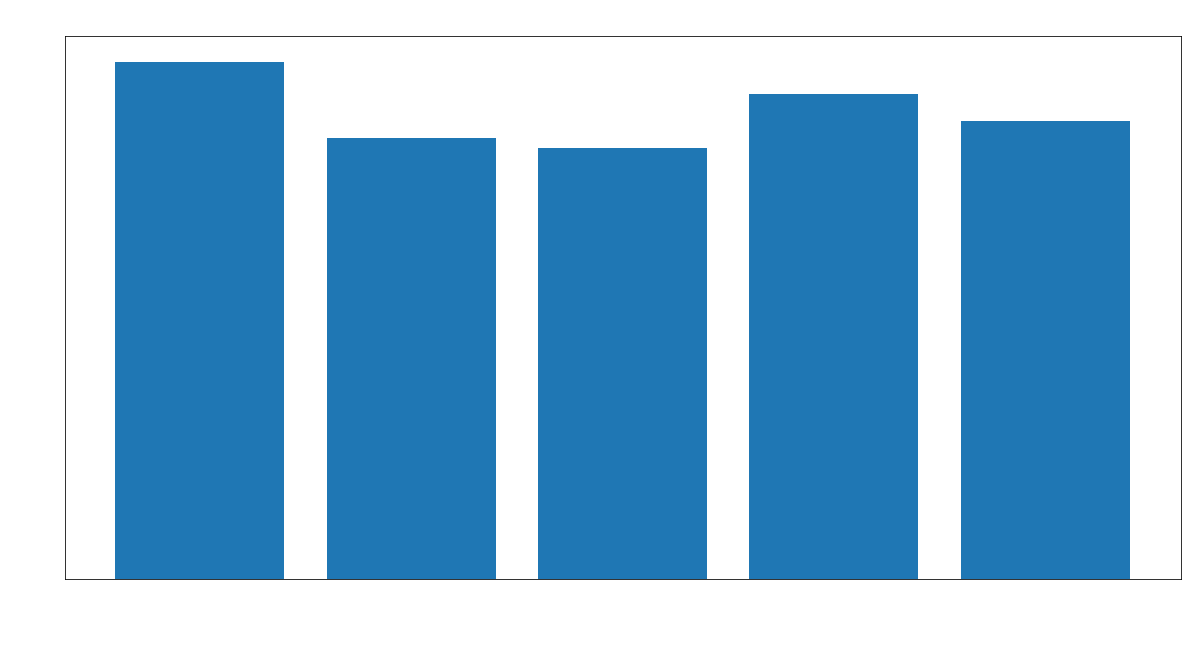

In [5]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

In [58]:
opacity = np.array(dataset_diseases['Opacity']).astype(str)
atelectasis = np.array(dataset_diseases['Atelectasis']).astype(str)
pneumothorax = np.array(dataset_diseases['Pneumothorax']).astype(str)
effusion = np.array(dataset_diseases['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset_diseases['labels_ref'] = all_labels

In [59]:
_, dataset_diseases = train_test_split(dataset_diseases, test_size = 0.45011, 
                                       random_state = 42, 
                                       stratify = dataset_diseases['labels_ref'])

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

Text(0, 0.5, 'Imagens')

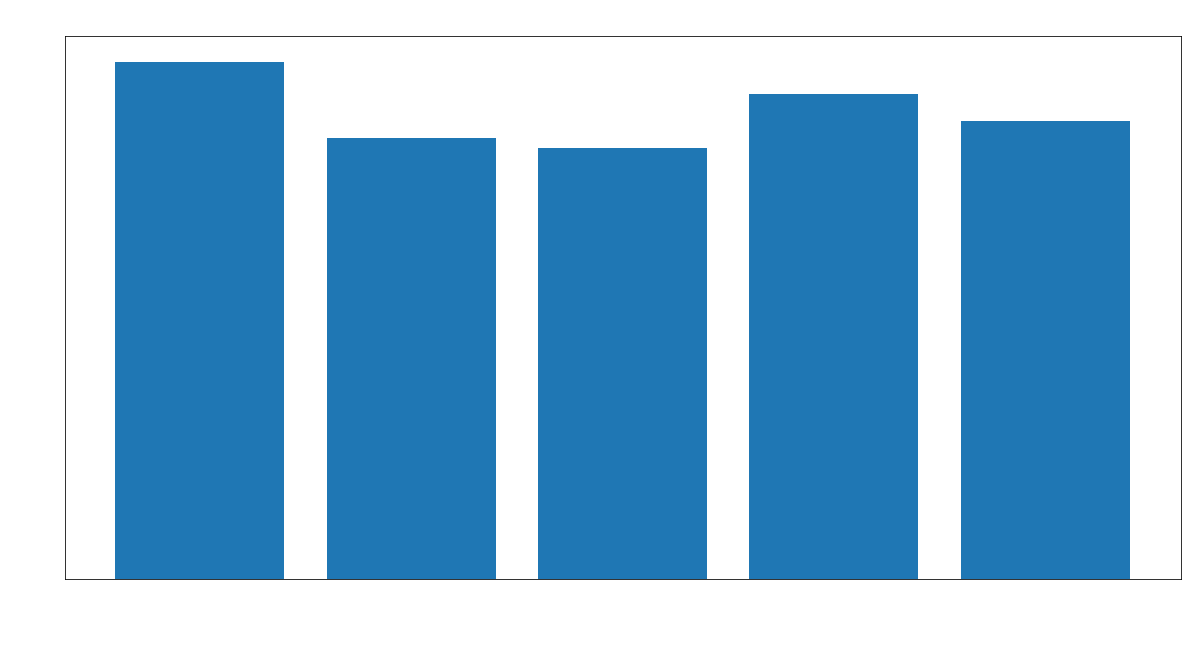

In [6]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

Text(0, 0.5, 'Imagens')

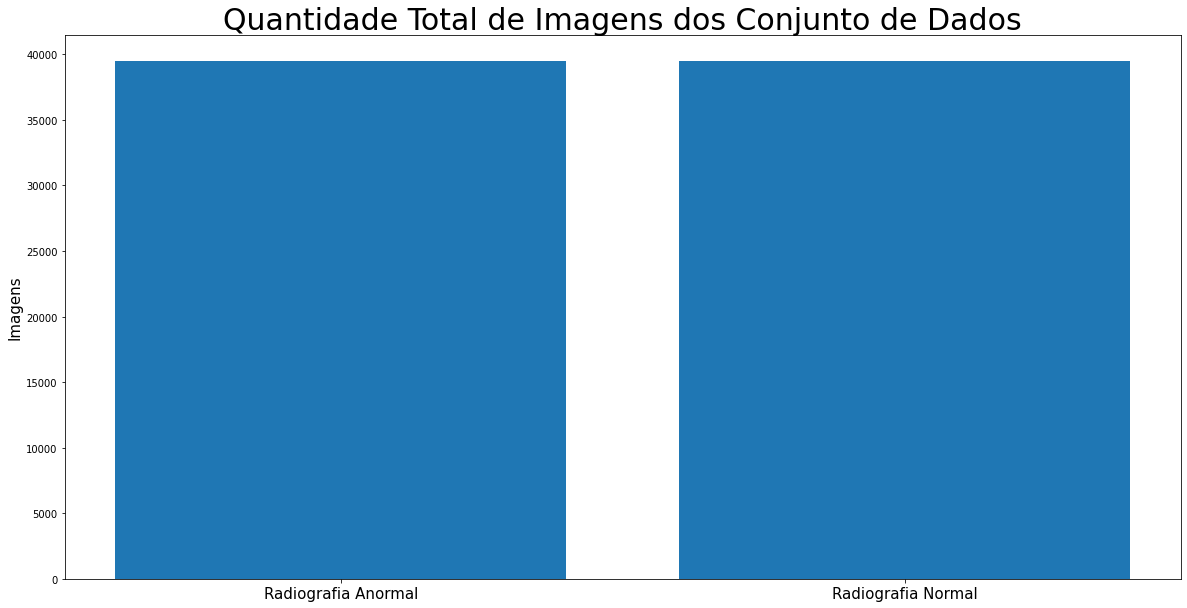

In [62]:
count_findings = list()
count_findings.append(dict(dataset['Abnormal'].value_counts())[1.0])
count_findings.append(dict(dataset['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_findings)
plt.xticks(rotation = 0, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

In [64]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['Abnormal'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                 stratify = f_val['Abnormal'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

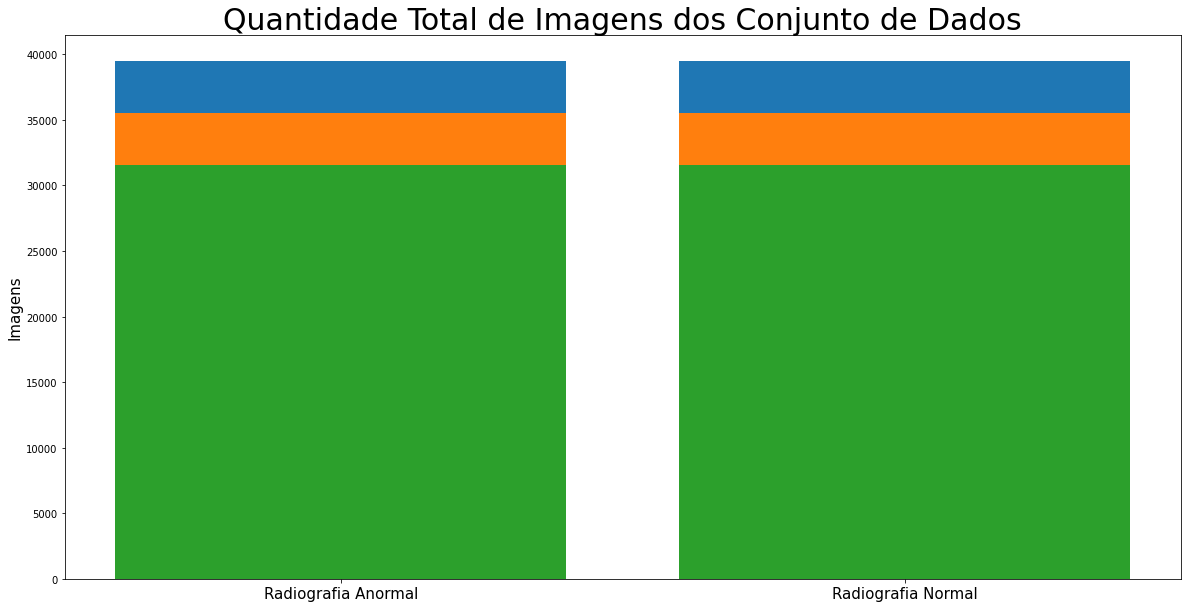

In [73]:
count_train, count_val, count_test = [], [], []
count_train.append(dict(f_train['Abnormal'].value_counts())[1.0])
count_train.append(dict(f_train['Abnormal'].value_counts())[0.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[1.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[0.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[1.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val, count_test), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_train)

plt.xticks(rotation = 0, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

### Applying Lung Localization to Images

In [89]:
train_path = list(f_train['Path'])
val_path = list(f_val['Path'])
test_path = list(f_test['Path'])

shutil.copy(src = '/content/drive/MyDrive/lung-localization/vgg/model_vgg5.zip', 
            dst = '/content/')

shutil.unpack_archive(filename = '/content/model_vgg5.zip', 
                      extract_dir = '', format = 'zip')

os.remove(path = '/content/model_vgg5.zip')

model_loc = tf.keras.models.load_model('/content/content/model_vgg5')

lung_localization = bbox_utils()

In [134]:
def make_localization(filename):
  '''
  performs lung localization on radiography images

  Args:
    filename (str) --> location of image file
  '''

  
  coordinates = lung_localization.make_localization_cnn(model = model_loc, path_file = filename)
  image_array = cv2.imread(filename = filename)
  crop_image = lung_localization.crop_image(image = image_array, list_coordinates = coordinates)
  lung_localization.save_img(image = crop_image, path_file = filename)

  return

In [ ]:
_ = list(map(make_localization, train_path))
_ = list(map(make_localization, val_path))
_ = list(map(make_localization, test_path))